# Identifying GHCN Stations Near Minneapolis Communities

We can use the functionality of GeoPandas and shapely to find weather stations in the GHCN archive that are near Minneapolis Wards and Communities.  The steps that we use are outlined below:

1.  Load the GeoJSONs for the Wards, Communities.
2.  Load the `.csv` files of GHCN stations.  Convert these to GeoPandas Data Frames.
3.  For each Ward and Community, find the three closest stations for reporting snowfall and snow depth.
4.  Write the station information back to `.csv` files.

In [1]:
# import the dependencies
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import geopy

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [2]:
# constants related to input and output

DATA_DIR = "data"
SNOW_STATIONS = "mnSnowStations.csv"
SNWD_STATIONS = "mnSnwdStations.csv"
OUTPUT_DIR = "output"
WARDS_FILE = "City_Council_Wards.geojson"
COMMUNITIES_FILE = "Communities.geojson"
NEIGHBORHOODS_FILE = "Minneapolis_Neighborhoods.geojson"

In [3]:
# helper functions to read files in.  GeoPandas read_file can load GeoJSONs

def load_csv(filename, data_dir=DATA_DIR):
    filepath = os.path.join(data_dir, filename)
    return pd.read_csv(filepath)

def load_geojson(filename, data_dir=DATA_DIR):
    filepath = os.path.join(data_dir, filename)
    return gpd.read_file(filepath)

# 1.  Load the GeoJSONs

In [4]:
wards = load_geojson(WARDS_FILE)
communities = load_geojson(COMMUNITIES_FILE)

In [5]:
wards.head()

,FID,BDNUM,Shape_STAr,Shape_STLe,geometry
0,1,1,2.044159e+08,71797.801731,"POLYGON ((-93.2268508021494 45.0132152671148, ..."
1,2,9,7.290147e+07,42091.446370,"POLYGON ((-93.2431848712514 44.955829056264, -..."
2,3,3,1.062057e+08,57104.348729,"POLYGON ((-93.2631316871618 45.0131674841788, ..."
3,4,4,1.471704e+08,57462.048968,"POLYGON ((-93.2991995476941 45.0511367258392, ..."
4,5,8,7.869230e+07,47568.406676,"POLYGON ((-93.2747782291209 44.9483536669077, ..."


# 2.  Load the Station Files

In [6]:
snow_stations = load_csv(SNOW_STATIONS)
snwd_stations = load_csv(SNWD_STATIONS)

In [7]:
snow_stations.head()

,id,latitude,longitude,elevation,state,name,gsn_flag,wmo_id,element,first_year,last_year
0,US1MNAA0004,45.4090,-93.3090,284.1,MN,SAINT FRANCIS 4.0 E,NaN,NaN,SNOW,2010,2019
1,US1MNAA0005,45.3846,-93.1553,280.4,MN,EAST BETHEL 3.1 NE,NaN,NaN,SNOW,2010,2019
2,US1MNAA0006,45.1708,-93.2570,277.1,MN,BLAINE 2.4 W,NaN,NaN,SNOW,2010,2019
3,US1MNAA0013,45.1648,-93.2855,267.6,MN,COON RAPIDS 1.4 ESE,NaN,NaN,SNOW,2011,2019
4,US1MNAA0015,45.1426,-93.1195,273.7,MN,LINO LAKES 2.5 SW,NaN,NaN,SNOW,2011,2019


In [8]:
def points_from_xy (longitudes, latitudes):
    return gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(longitudes, latitudes)])
        

In [9]:
# Convert the Pandas DataFrames to GeoPandas GeoDataFrames:
snow_gdf = gpd.GeoDataFrame(snow_stations,\
                            geometry=points_from_xy(snow_stations.longitude, snow_stations.latitude))
snow_gdf.head()

,id,latitude,longitude,elevation,state,name,gsn_flag,wmo_id,element,first_year,last_year,geometry
0,US1MNAA0004,45.4090,-93.3090,284.1,MN,SAINT FRANCIS 4.0 E,NaN,NaN,SNOW,2010,2019,POINT (-93.309 45.409)
1,US1MNAA0005,45.3846,-93.1553,280.4,MN,EAST BETHEL 3.1 NE,NaN,NaN,SNOW,2010,2019,POINT (-93.1553 45.3846)
2,US1MNAA0006,45.1708,-93.2570,277.1,MN,BLAINE 2.4 W,NaN,NaN,SNOW,2010,2019,POINT (-93.25700000000001 45.1708)
3,US1MNAA0013,45.1648,-93.2855,267.6,MN,COON RAPIDS 1.4 ESE,NaN,NaN,SNOW,2011,2019,POINT (-93.2855 45.1648)
4,US1MNAA0015,45.1426,-93.1195,273.7,MN,LINO LAKES 2.5 SW,NaN,NaN,SNOW,2011,2019,POINT (-93.1195 45.1426)


In [10]:
snwd_gdf = gpd.GeoDataFrame(snwd_stations,\
                            geometry=points_from_xy(snwd_stations.longitude, snwd_stations.latitude))
snwd_gdf.head()

,id,latitude,longitude,elevation,state,name,gsn_flag,wmo_id,element,first_year,last_year,geometry
0,US1MNAA0004,45.4090,-93.3090,284.1,MN,SAINT FRANCIS 4.0 E,NaN,NaN,SNWD,2010,2019,POINT (-93.309 45.409)
1,US1MNAA0005,45.3846,-93.1553,280.4,MN,EAST BETHEL 3.1 NE,NaN,NaN,SNWD,2010,2019,POINT (-93.1553 45.3846)
2,US1MNAA0054,45.1947,-93.3749,269.1,MN,ANOKA 1.3 SSE,NaN,NaN,SNWD,2015,2019,POINT (-93.3749 45.1947)
3,US1MNAT0004,46.7138,-93.2885,383.7,MN,MCGREGOR 7.3 N,NaN,NaN,SNWD,2012,2019,POINT (-93.2885 46.7138)
4,US1MNBK0006,46.7985,-96.1218,442.9,MN,LAKE PARK 6.0 S,NaN,NaN,SNWD,2013,2019,POINT (-96.12179999999999 46.7985)


# 3.  Find Stations Closest to Each Unit

In [11]:
# A helper function to find the required units:
def three_closest_stations(unit, stations_df):
    
    indices = stations_df.geometry.distance(unit).argsort()[:3]
    return stations_df.loc[indices, 'id']

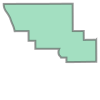

In [12]:
wards.geometry[0]

In [13]:
three_closest_stations(wards.geometry[0], snow_gdf)

98     US1MNHN0065
320    USC00214884
76     US1MNHN0009
Name: id, dtype: object

In [14]:
snow_gdf[snow_gdf.id.isin(three_closest_stations(wards.geometry[0], snow_gdf))]

,id,latitude,longitude,elevation,state,name,gsn_flag,wmo_id,element,first_year,last_year,geometry
76,US1MNHN0009,45.0039,-93.2895,272.2,MN,MINNEAPOLIS 3.0 NNW,NaN,NaN,SNOW,2009,2019,POINT (-93.2895 45.0039)
98,US1MNHN0065,45.0083,-93.2363,266.4,MN,MINNEAPOLIS 2.4 NE,NaN,NaN,SNOW,2011,2019,POINT (-93.2363 45.0083)
320,USC00214884,44.9783,-93.2469,229.8,MN,LOWER ST ANTHONY FALLS,NaN,NaN,SNOW,1991,2019,POINT (-93.2469 44.9783)


In [15]:
three_closest_stations(wards.geometry[0], snow_gdf).reset_index().loc[0, 'id']

'US1MNHN0065'

In [16]:
# A function to return the three closest snow and snwd stations for each unit in a GeoPandas GeoDataFrame:

def three_closest (geodf, snow_geodf, snwd_geodf):
    
    new_geodf = geodf.copy()
    new_geodf['snow_1'] = ''
    new_geodf['snow_2'] = ''
    new_geodf['snow_3'] = ''
    new_geodf['snwd_1'] = ''
    new_geodf['snwd_2'] = ''
    new_geodf['snwd_3'] = ''
    
    num_features = new_geodf.shape[0]
    for idx in range(num_features):
        snow_neighbors = three_closest_stations(new_geodf.geometry[idx], snow_geodf)
        new_geodf.loc[idx, 'snow_1'] = snow_neighbors.reset_index().loc[0, 'id']
        new_geodf.loc[idx, 'snow_2'] = snow_neighbors.reset_index().loc[1, 'id']
        new_geodf.loc[idx, 'snow_3'] = snow_neighbors.reset_index().loc[2, 'id']
        snwd_neighbors = three_closest_stations(new_geodf.geometry[idx], snwd_geodf)
        new_geodf.loc[idx, 'snwd_1'] = snwd_neighbors.reset_index().loc[0, 'id']
        new_geodf.loc[idx, 'snwd_2'] = snwd_neighbors.reset_index().loc[1, 'id']
        new_geodf.loc[idx, 'snwd_3'] = snwd_neighbors.reset_index().loc[2, 'id']
        
    return new_geodf

In [17]:
ward_neighbors = three_closest(wards, snow_gdf, snwd_gdf)
ward_neighbors

,FID,BDNUM,Shape_STAr,Shape_STLe,geometry,snow_1,snow_2,snow_3,snwd_1,snwd_2,snwd_3
0,1,1,2.044159e+08,71797.801731,"POLYGON ((-93.2268508021494 45.0132152671148, ...",US1MNHN0065,USC00214884,US1MNHN0009,USC00214884,US1MNHN0009,USC00218450
1,2,9,7.290147e+07,42091.446370,"POLYGON ((-93.2431848712514 44.955829056264, -...",USC00214884,US1MNHN0155,US1MNHN0090,USC00214884,US1MNHN0022,US1MNHN0009
2,3,3,1.062057e+08,57104.348729,"POLYGON ((-93.2631316871618 45.0131674841788, ...",USC00214884,US1MNHN0065,US1MNHN0009,USC00214884,US1MNHN0009,USC00218450
3,4,4,1.471704e+08,57462.048968,"POLYGON ((-93.2991995476941 45.0511367258392, ...",US1MNHN0009,US1MNHN0128,US1MNHN0134,US1MNHN0009,US1MNHN0128,US1MNHN0134
4,5,8,7.869230e+07,47568.406676,"POLYGON ((-93.2747782291209 44.9483536669077, ...",US1MNHN0028,US1MNHN0090,US1MNHN0155,US1MNHN0022,US1MNHN0078,USC00214884
5,6,10,8.009826e+07,50210.941760,"POLYGON ((-93.28794023236701 44.9632388924159,...",US1MNHN0022,US1MNHN0028,US1MNHN0125,US1MNHN0022,USC00214884,US1MNHN0009
6,7,2,1.410789e+08,70420.515049,"POLYGON ((-93.2365038634035 44.991500104945, -...",USC00214884,US1MNHN0065,US1MNRM0022,USC00214884,USC00218450,US1MNRM0054
7,8,5,1.354790e+08,51967.153287,"POLYGON ((-93.2892789754836 45.0130314787328, ...",US1MNHN0009,US1MNHN0128,USC00214884,US1MNHN0009,US1MNHN0128,USC00214884
8,9,7,1.289673e+08,64143.300789,"POLYGON ((-93.27570597887591 44.9785953052088,...",USC00214884,US1MNHN0022,US1MNHN0009,USC00214884,US1MNHN0022,US1MNHN0009
9,10,11,1.470060e+08,75386.169577,"POLYGON ((-93.2473140989744 44.9251255311669, ...",US1MNHN0028,US1MNHN0090,US1MNHN0085,USW00014922,US1MNHN0078,US1MNHN0022


In [18]:
ward_neighbors.rename(columns = {'BDNUM': 'Ward'}, inplace=True)
ward_neighbors.drop(columns = ['FID', 'Shape_STAr', 'Shape_STLe', 'geometry'], inplace=True)
ward_neighbors

,Ward,snow_1,snow_2,snow_3,snwd_1,snwd_2,snwd_3
0,1,US1MNHN0065,USC00214884,US1MNHN0009,USC00214884,US1MNHN0009,USC00218450
1,9,USC00214884,US1MNHN0155,US1MNHN0090,USC00214884,US1MNHN0022,US1MNHN0009
2,3,USC00214884,US1MNHN0065,US1MNHN0009,USC00214884,US1MNHN0009,USC00218450
3,4,US1MNHN0009,US1MNHN0128,US1MNHN0134,US1MNHN0009,US1MNHN0128,US1MNHN0134
4,8,US1MNHN0028,US1MNHN0090,US1MNHN0155,US1MNHN0022,US1MNHN0078,USC00214884
5,10,US1MNHN0022,US1MNHN0028,US1MNHN0125,US1MNHN0022,USC00214884,US1MNHN0009
6,2,USC00214884,US1MNHN0065,US1MNRM0022,USC00214884,USC00218450,US1MNRM0054
7,5,US1MNHN0009,US1MNHN0128,USC00214884,US1MNHN0009,US1MNHN0128,USC00214884
8,7,USC00214884,US1MNHN0022,US1MNHN0009,USC00214884,US1MNHN0022,US1MNHN0009
9,11,US1MNHN0028,US1MNHN0090,US1MNHN0085,USW00014922,US1MNHN0078,US1MNHN0022


In [19]:
ward_neighbors.snow_1.unique()

array(['US1MNHN0065', 'USC00214884', 'US1MNHN0009', 'US1MNHN0028',
       'US1MNHN0022', 'US1MNHN0085'], dtype=object)

In [20]:
ward_neighbors.to_csv(os.path.join(OUTPUT_DIR, "ward_neighboring_stations.csv"), index=False)

# 4.  Repeat the above steps for communities

In [21]:
community_neighbors = three_closest(communities, snow_gdf, snwd_gdf)
community_neighbors

,FID,CommName,geometry,snow_1,snow_2,snow_3,snwd_1,snwd_2,snwd_3
0,1,Camden,"POLYGON ((-93.31949186501051 45.0512462469094,...",US1MNHN0009,US1MNHN0128,US1MNHN0134,US1MNHN0009,US1MNHN0128,US1MNHN0134
1,2,Northeast,"POLYGON ((-93.22685080614011 45.0132165472863,...",US1MNHN0065,USC00214884,US1MNHN0009,USC00214884,US1MNHN0009,USC00218450
2,3,Near North,"POLYGON ((-93.3178372365291 45.013260021455, -...",US1MNHN0009,US1MNHN0128,USC00214884,US1MNHN0009,US1MNHN0128,USC00214884
3,4,Central,"POLYGON ((-93.27211391203549 44.9921313605316,...",USC00214884,US1MNHN0009,US1MNHN0065,USC00214884,US1MNHN0009,US1MNHN0022
4,5,University,"POLYGON ((-93.2076071706838 45.0015313002637, ...",USC00214884,US1MNHN0065,US1MNRM0022,USC00214884,US1MNHN0009,USC00218450
5,6,Calhoun Isle,"POLYGON ((-93.3145043457895 44.9807350118223, ...",US1MNHN0022,US1MNHN0009,US1MNHN0028,US1MNHN0022,US1MNHN0009,US1MNHN0089
6,7,Powderhorn,"POLYGON ((-93.27019812084311 44.9626922756977,...",US1MNHN0155,US1MNHN0090,US1MNHN0085,USC00214884,US1MNHN0022,US1MNHN0009
7,8,Longfellow,"POLYGON ((-93.2417939467181 44.9643295949123, ...",US1MNHN0155,US1MNRM0054,US1MNHN0085,US1MNRM0054,USC00214884,USW00014922
8,9,Southwest,"POLYGON ((-93.3213533207046 44.937741141166, -...",US1MNHN0125,US1MNHN0028,US1MNHN0078,US1MNHN0022,US1MNHN0078,US1MNHN0089
9,10,Nokomis,"POLYGON ((-93.22372002735629 44.9269197091415,...",US1MNHN0090,US1MNHN0085,US1MNHN0155,US1MNRM0054,USW00014922,US1MNHN0078


In [22]:
community_neighbors.rename(columns = {'CommName': 'Community'}, inplace=True)
community_neighbors.drop(columns = ['FID', 'geometry'], inplace=True)
community_neighbors

,Community,snow_1,snow_2,snow_3,snwd_1,snwd_2,snwd_3
0,Camden,US1MNHN0009,US1MNHN0128,US1MNHN0134,US1MNHN0009,US1MNHN0128,US1MNHN0134
1,Northeast,US1MNHN0065,USC00214884,US1MNHN0009,USC00214884,US1MNHN0009,USC00218450
2,Near North,US1MNHN0009,US1MNHN0128,USC00214884,US1MNHN0009,US1MNHN0128,USC00214884
3,Central,USC00214884,US1MNHN0009,US1MNHN0065,USC00214884,US1MNHN0009,US1MNHN0022
4,University,USC00214884,US1MNHN0065,US1MNRM0022,USC00214884,US1MNHN0009,USC00218450
5,Calhoun Isle,US1MNHN0022,US1MNHN0009,US1MNHN0028,US1MNHN0022,US1MNHN0009,US1MNHN0089
6,Powderhorn,US1MNHN0155,US1MNHN0090,US1MNHN0085,USC00214884,US1MNHN0022,US1MNHN0009
7,Longfellow,US1MNHN0155,US1MNRM0054,US1MNHN0085,US1MNRM0054,USC00214884,USW00014922
8,Southwest,US1MNHN0125,US1MNHN0028,US1MNHN0078,US1MNHN0022,US1MNHN0078,US1MNHN0089
9,Nokomis,US1MNHN0090,US1MNHN0085,US1MNHN0155,US1MNRM0054,USW00014922,US1MNHN0078


In [23]:
community_neighbors.snow_1.unique()

array(['US1MNHN0009', 'US1MNHN0065', 'USC00214884', 'US1MNHN0022',
       'US1MNHN0155', 'US1MNHN0125', 'US1MNHN0090'], dtype=object)

In [24]:
community_neighbors.to_csv(os.path.join(OUTPUT_DIR, "community_neighboring_stations.csv"), index=False)

# Conclusion

We can now use the above results to estimate snowfall totals and snow depths for each ward and community by looking at the average of the amounts for the three closest stations.